$$\textbf{Chad Schupbach}$$

***

The default backend engine for Keras (Tensorflow) uses CUDA, an API only supported by NVIDIA GPUs. We utilize [PlaidML](https://github.com/plaidml/plaidml) as Keras backend engine, which has Metal support for the current device GPU (AMD Radeon Pro 5300M). We reassign Keras backend engine as PlaidML in the following two code blocks.

In [1]:
import os

In [2]:
path = '/Users/chadschupbach/opt/anaconda3/'
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
os.environ['RUNFILES_DIR'] = path + 'share/plaidml'
os.environ['PLAIDML_NATIVE_PATH'] = path + 'lib/libplaidml.dylib'

In [3]:
import numpy as np
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time
from src import utils

Using plaidml.keras.backend backend.


# Fashion MNIST

The MNIST digits dataset is one of the most widely used classification datasets. However, it is now too easy. We use it here because it comes with Keras and does not need to be downloaded elsewhere. The dataset also trains relatively fast for those not using GPU

## Initialization

Load the entire MNIST dataset containing 60000 training images and 10000 testing images across 10 classes $\{0,1,\dots,8,9\}$.

In [4]:
x_train, y_train, x_test, y_test, input_shape = utils.load_mnist(dataset='fashion')

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


The first 10 samples from each class are shown below.

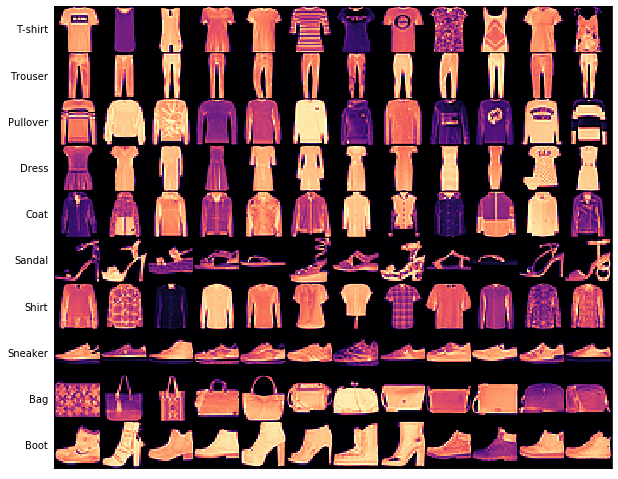

In [5]:
utils.plot_samples(x_train, y_train, dataset='fashion')

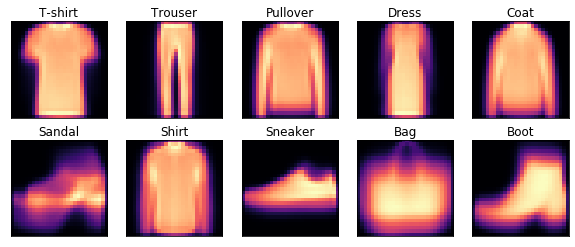

In [6]:
utils.plot_class_means(x_train, y_train, dataset='fashion')

For the ensemble, we will train 10 models with the same architecture using a batch size of 128.

In [7]:
n_classes = y_test.shape[-1]
n_models = 10
batch_size = 128

The architecture of each CNN model is as follows:

In [8]:
model = [None] * n_models
for i in range(n_models):
    model[i] = Sequential()
    model[i].add(Conv2D(16, 3, padding='same', activation='relu',
                        input_shape=(28, 28, 1)))
    model[i].add(Conv2D(16, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, activation='relu'))
    model[i].add(Flatten())
    model[i].add(Dropout(0.25))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(n_classes, activation='softmax'))
    model[i].compile(optimizer='nadam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [9]:
model[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
__________

We assign model checkpoints and early stopping criterion below. The checkpoints save parameter weights of the best training epoch based on validation accuracy to files in the `models` directory. We also set early stopping criterion that indicates convergence when no decrease in validation loss is observed over 10 epochs.

In [10]:
checkpoint = []
earlystop = []
for i in range(n_models):
    checkpoint += [ModelCheckpoint(filepath=f'models/fashion/best_weights_{i}.hdf5',
                                   monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')]
    earlystop += [EarlyStopping(monitor='val_loss', patience=8, mode='min')]

If the early stopping criterion is not met, we end the training session of each model after 25 epochs. Because we need a validation set for the checkpoints and convergence criterion, we randomly split the training data into 80% training and 20% validation prior to each training session. It's not uncommon to see similar models implemented using the testing set for model validation. While it's tempting given that the validation set is not actually being used in training, this strategy will result in model selection bias and should be avoided.

In [11]:
start = time.time()
epochs = 25
ledger = []
for i in range(n_models):
    clear_output(wait=True)
    print(f'CNN_{i+1}\n' + '='*50)
    x_train2, x_valid, y_train2, y_valid = train_test_split(x_train, y_train,
                                                            test_size=0.2)
    ledger += [model[i].fit(x_train2, y_train2, batch_size=batch_size,
                            epochs=epochs, verbose=1,
                            callbacks=[checkpoint[i], earlystop[i]],
                            validation_data=(x_valid, y_valid))]
runtime = time.time() - start

CNN_10
Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 30s 615us/step - loss: 0.8119 - acc: 0.6985 - val_loss: 0.3847 - val_acc: 0.8577
Epoch 2/25
48000/48000 [==============================] - 29s 597us/step - loss: 0.4375 - acc: 0.8457 - val_loss: 0.3127 - val_acc: 0.8849
Epoch 3/25
48000/48000 [==============================] - 28s 587us/step - loss: 0.3521 - acc: 0.8764 - val_loss: 0.3074 - val_acc: 0.8899
Epoch 4/25
48000/48000 [==============================] - 29s 599us/step - loss: 0.3124 - acc: 0.8909 - val_loss: 0.2654 - val_acc: 0.9037
Epoch 5/25
48000/48000 [==============================] - 29s 599us/step - loss: 0.2927 - acc: 0.8991 - val_loss: 0.2511 - val_acc: 0.9119
Epoch 6/25
48000/48000 [==============================] - 29s 608us/step - loss: 0.2713 - acc: 0.9072 - val_loss: 0.2385 - val_acc: 0.9169
Epoch 7/25
48000/48000 [==============================] - 29s 597us/step - loss: 0.2545 - acc: 0.9122 - val_l

In [12]:
print('Total runtime: {:.2f} min'.format(runtime / 60))

Total runtime: 104.01 min


In [13]:
utils.training_summary(model, ledger, x_test, y_test, dataset='fashion')

,Epoch,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc
Model 0,14.0,0.17526,0.23796,0.26342,0.9393,0.9207,0.9115
Model 1,21.0,0.16420,0.21470,0.25122,0.9442,0.9248,0.9162
Model 2,13.0,0.17669,0.21911,0.25031,0.9392,0.9214,0.9149
Model 3,19.0,0.16811,0.21917,0.25791,0.9424,0.9239,0.9185
Model 4,19.0,0.16137,0.22712,0.25066,0.9444,0.9232,0.9194
Model 5,19.0,0.17417,0.22683,0.27044,0.9390,0.9214,0.9133
Model 6,18.0,0.17618,0.21909,0.25490,0.9387,0.9250,0.9187
Model 7,19.0,0.16887,0.22961,0.25877,0.9407,0.9236,0.9159
Model 8,22.0,0.17134,0.22341,0.28797,0.9406,0.9256,0.9157
Model 9,15.0,0.17246,0.21593,0.24215,0.9394,0.9272,0.9192


In [14]:
test_act, test_pred, test_res = utils.ensemble_results(model, x_train, y_train,
                                                       x_test, y_test)
# 0.9664, 0.9352

Ensemble Train Accuracy: 0.9666
Ensemble Test Accuracy: 0.9343


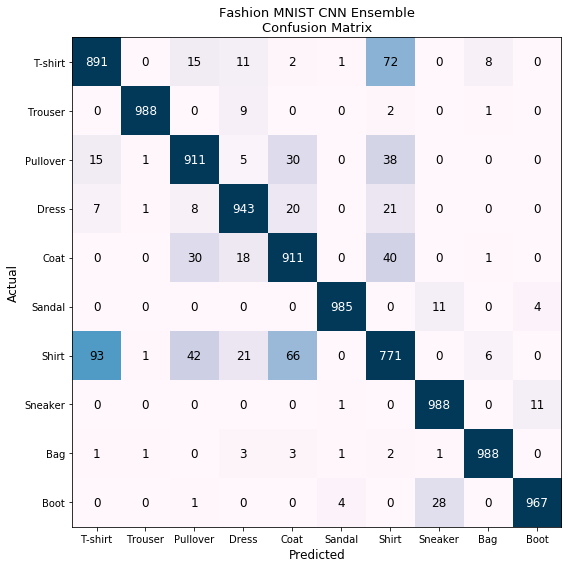

In [15]:
utils.plot_confusion(test_act, test_pred, dataset='fashion')

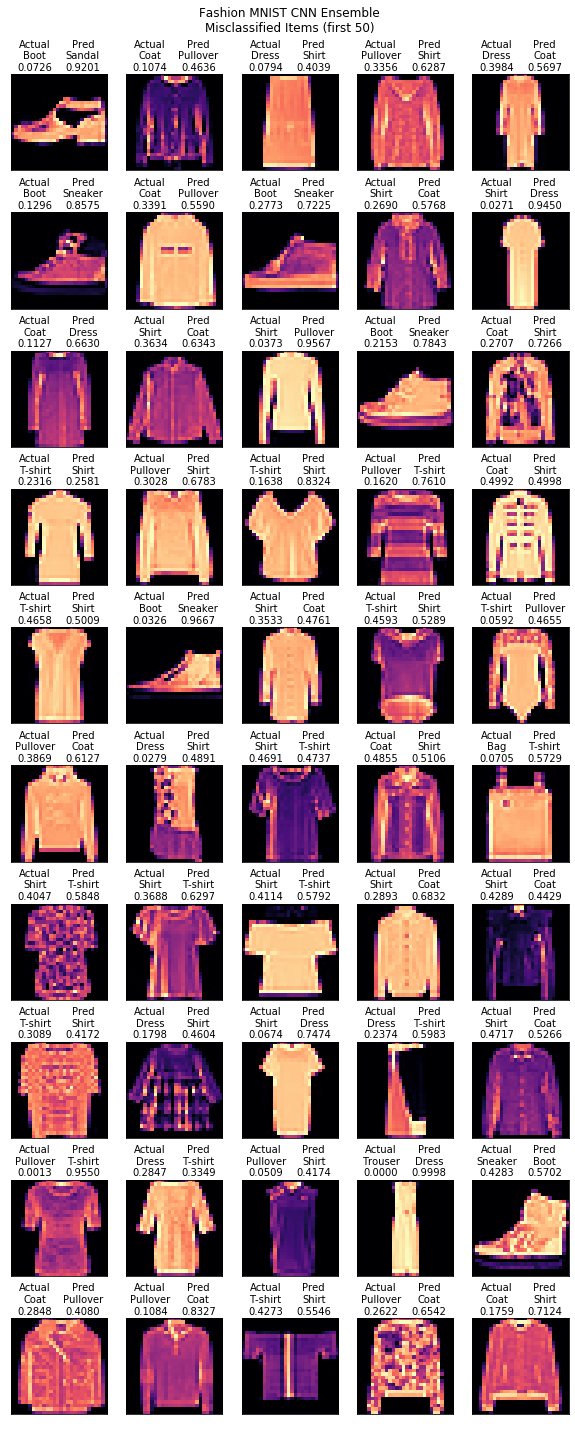

In [16]:
utils.plot_misclassified(x_test, test_pred, test_act, test_res, dataset='fashion')

In [48]:
np.random.seed(42)
seed = np.random.randint(0, 1e6, 10)

In [49]:

x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=10000,
                                                    random_state=random_seed)
# history[j] = model[j].fit_generator(datagen.flow(x_train2,y_train2, batch_size=64),
#                                     epochs = epochs, validation_data = (x_val,y_val),
#                                     verbose = 0, steps_per_epoch=(len(x_train)//64),validation_steps=(len(x_val)//64),callbacks=[annealer])

[array([12,  6, 17]),
 array([12, 11, 14]),
 array([ 4, 14, 15]),
 array([16,  2, 18]),
 array([ 4,  8, 17]),
 array([1, 0, 8]),
 array([13,  5,  0]),
 array([11,  9,  1]),
 array([10,  0, 17]),
 array([7, 6, 5])]